# Chapter 9. CNN Architecture

## Case Study
- AlexNet
- VGG
- GoogLeNet
- ResNet

## Also
- NiN (Network in Network)
- Wide ResNet
- ResNetXT
- Stochastic Depth
- DenseNet
- FractalNet
- SqueezeNet

---

## AlexNet

image task에서 CNN이 주목받는 계기가 되는 모델.

first large scale / do well at image

more layers at total than LeNet-5

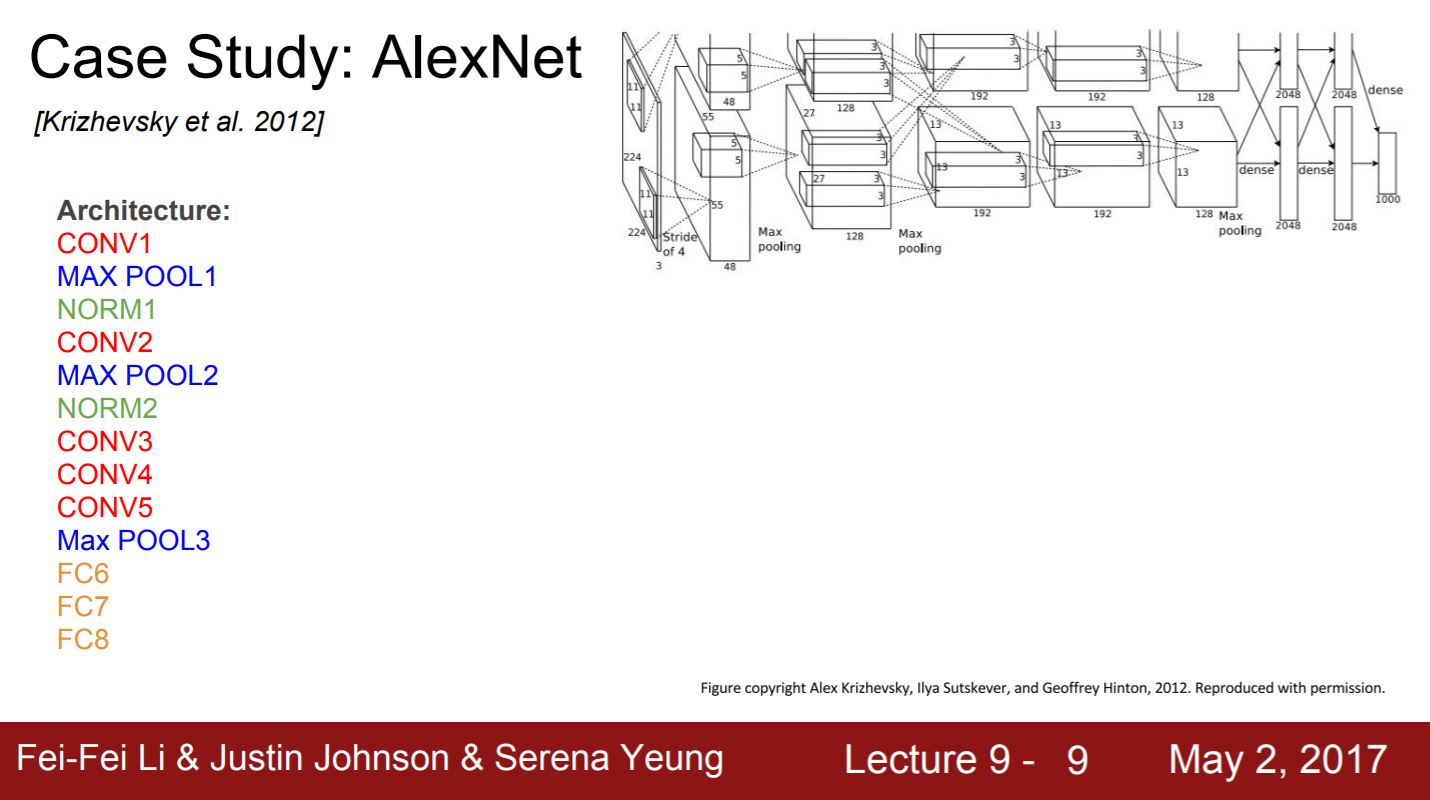

**Conv - Max Pool - Norm** 형태로 이루어져 있음.
(Norm은 요즘 쓰이지 않음)

**첫 Conv1에서의 계산**

> - Input: 227x227x3 image 
> 
> [Conv1 96 11x11, stride 4]
> - Output Volume: (227-11)/4 + 1 = 55

> *55x55x96* size,
>
> parameters: (11x11x3)x96 = 35k

output volume & parameters -> computation scale과 관련이 많음.



**다음 Pooling Layer에서의 계산**

앞에서의 output size: 55

> - Input: 55x55x96 Layer
> 
> [POOL1 3x3 filters, stride 2]
>
> - Output Volume: 27x27x96
>   - (55-3)/2 + 1

> Parameters: **0**

- Pool Layer: no parameters(no weights) - always 0
- Conv: always have weight



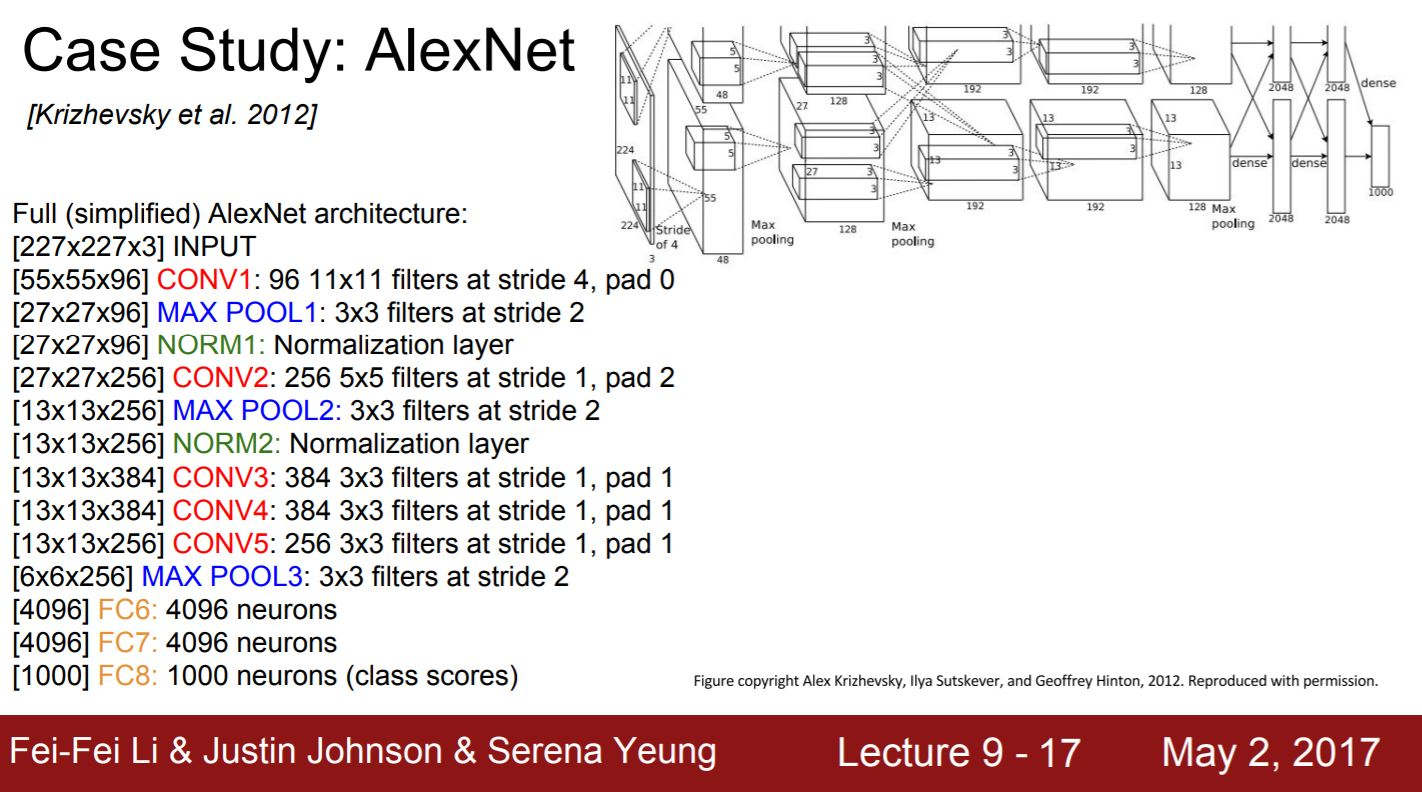

계속 계산하다 보면 위 사진처럼 계산됨. 

end: FC layer

last → softmax, 1000 imageNet Classes

### 특징

- first use of **ReLu**

- used **Norm** Layers - not common anymore

- heavy **data augmentation**

- dropout 0.5

- batch size 128

- SGD Momentum 0.9

- Learning rate 1e-2, reduced by 10 manually when val accuracy plateaus

- L2 **weight decay** 5e-4
  - Weight decay: regularzation의 한 방법, 모델 복잡성↓

- 7 CNN **ensemble**: 18.2 % -> 15.4%

#### *one difference*: split to two

reason: AlexNet GPU have only 3 gate of memory, so it needs to split to 2 GPU

> 55x55x96 → [55x55x48] x 2

대용량으로 모델을 만드는 곳에서 현재에도 많이 사용하는 기법!

> **CONV1, CONV2, CONV4, CONV5**
>
> Connections *only* with feature maps on *same* GPU
>
> 서로 나뉘어진 값을 봄 → 동일 GPU 상에서의 features만 받으며 따라서 나뉘어진 48개의 features만 확인

> **CONV3, FC6, FC7, FC8**
>
> Connections with *all* feature maps in preceding layer, *communication across* GPUs
> - GPU do talk each other
>
> 전체 GPU와 연결되어 있고 GPU 간의 통신이 됨 → 이전 입력 layer의 전체 depth 가져올 수 있음



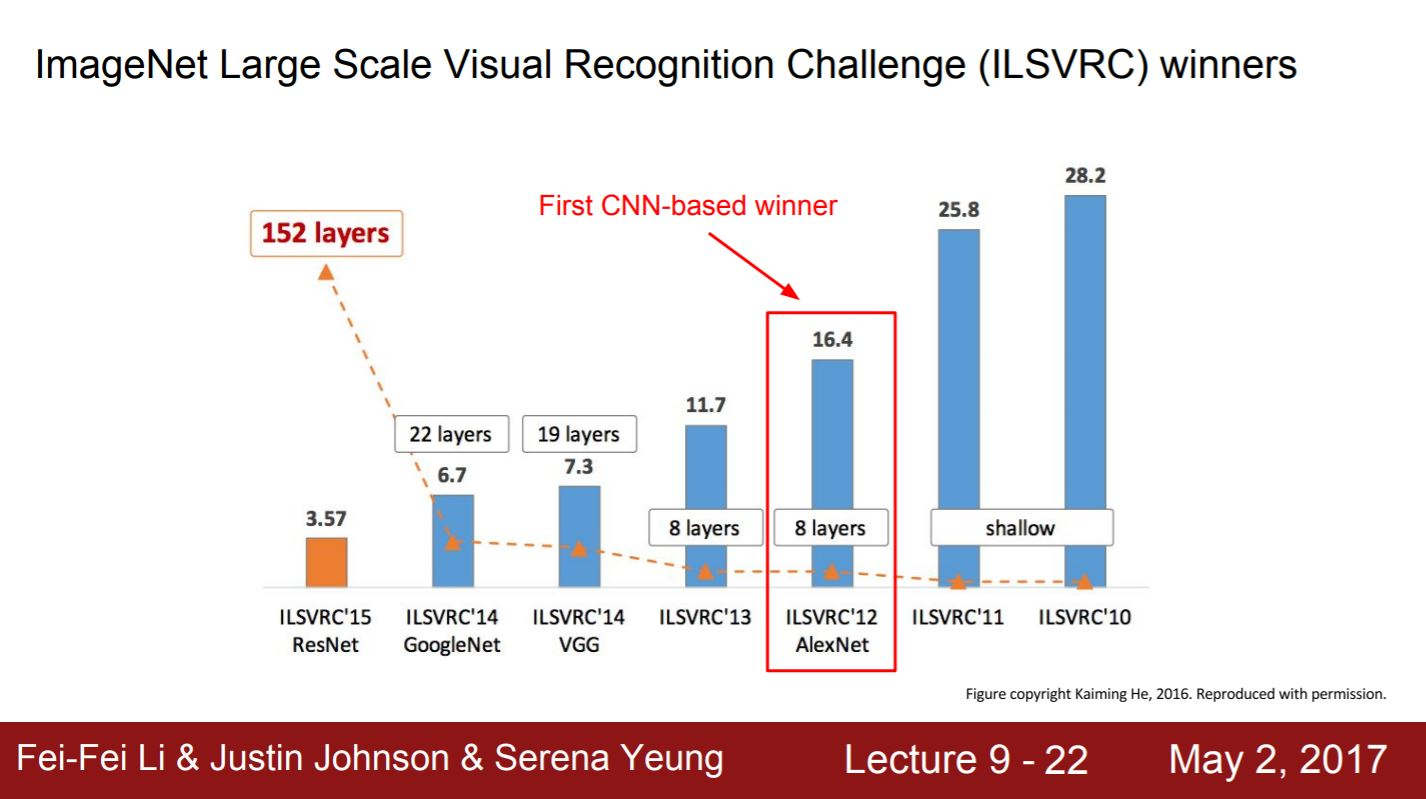

- AlexNet: First CNN-based winner
  - most common to use
  - first deep learning architecture that use ConvNet at ImageNet
  - CNN 발전, transfer learning으로 많이 사용하기도 함

- ZFNet: same layer with AlexNet, general style
  - Different Size of ConvNet, stride, Conv3,4,5, Hyperparameters
  - Same architecture

- VGG: Deeper Networks - 19 Layers (2014)
  - much *deeper*, *smaller filters*

- GoogleNet: Deeper Networks - 22 Layers (2014)

2014, both strong networks

## VGGNet

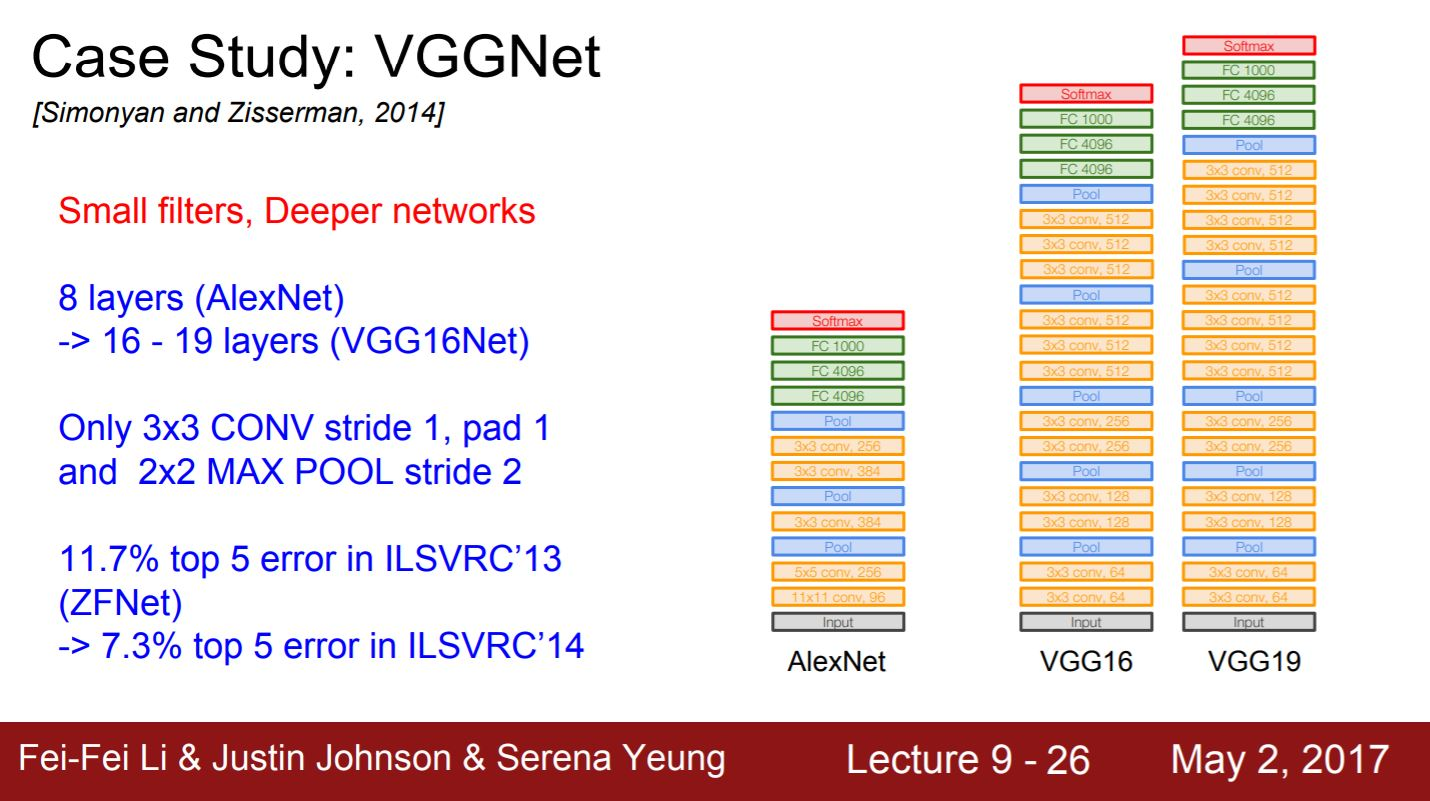

**Small Filters, Deeper Networks**

- smaller filters

- very simple structure
  - only 3x3 conv
    - Stack of three 3x3 conv (stride 1) layers → **effective receptive field** as 7x7
      - 3x3 → 5x5 → 7x7
      - 같은 효과를 내는데 parameter의 수는 줄어듦
        - fewer parameters: 3*(3^2 * C^2) vs 7^2 * C^2
  - stride: 1, pad: 1
  - 2x2 max pool & stride 2



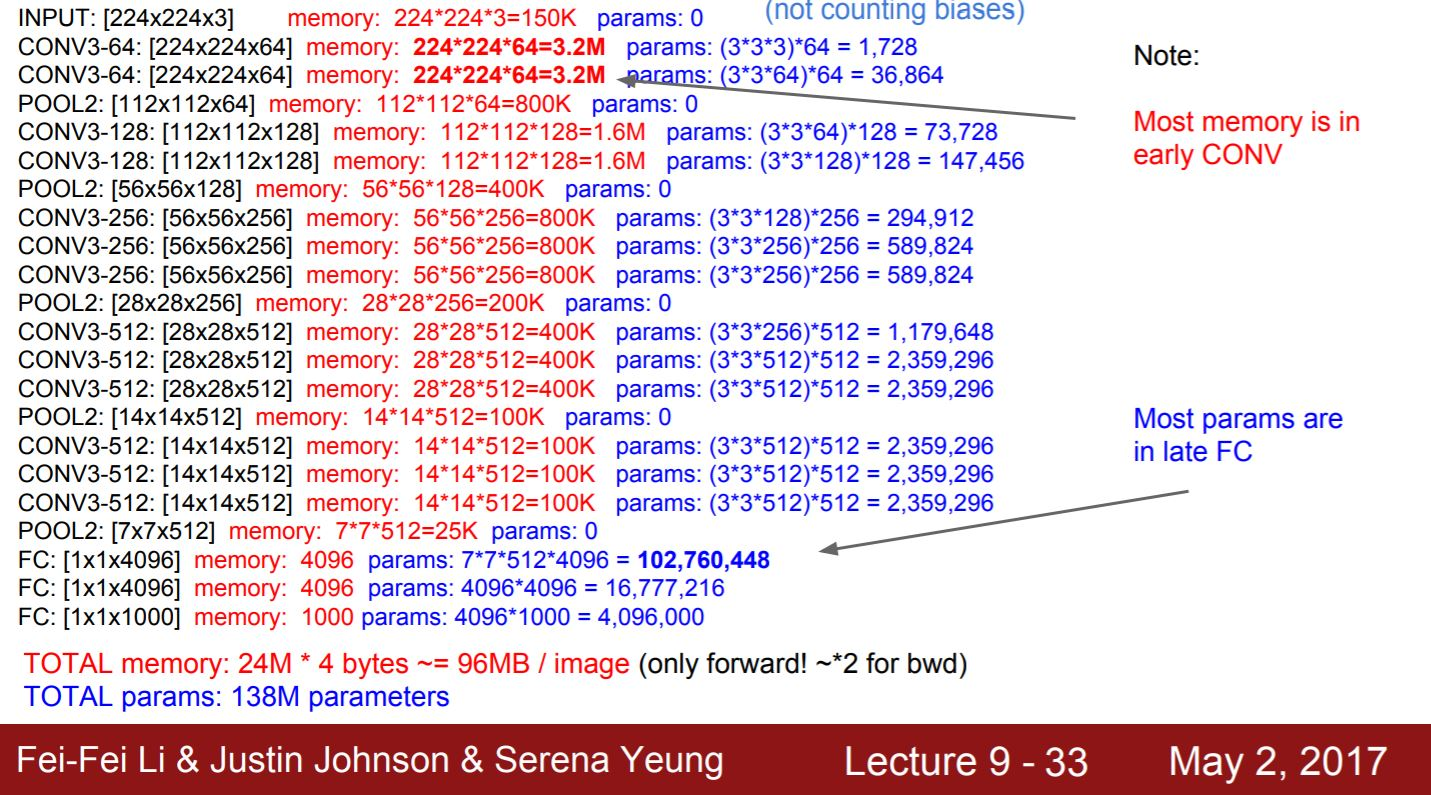

전체 파라미터를 계산하면 윗 사진처럼 계산된다. 

- FC Layer: **parameter is very big**

- Total Memory: **heavy**
  - counting up all of numbers. 4 bits per number, scale of the number usage is heavy 

- Total Parameter: **many**
  - vs 36M of AlexNet

VGG는 메모리 사용량이 많다는 단점이 있고, parameter의 수도 많다.

- Memory Usage가 가장 많은 곳: CONV3

- 가장 많은 Parameter을 사용한 곳: FC1

개수를 줄이기 위하여 최근에는 이것을 아예 버리는 경우도 존재한다.


### 특징

- 2nd in classification, 1st in **localization**
  - localization: classification & bounding box (additional) - relation with detection

- Similar training procedure as Krizhevsky 2012

- *No* Local Responce Normalization (LRN) 

- Use VGG16 or VGG19 (VGG19 only slightly better, more memory)
  - commonly use 16

- Use ensembles for best results

- FC7 features generalize well to other tasks
  - good **feature representation**
  - **generalize** 잘 되어 있음


## GoogLeNet

**Deeper Networks, with computational efficiency**

큰 계산량을 효율적으로 처리. parameter의 수도 5M로 매우 작고 (VGG: ...) AlexNet보다 없는 수준.


### 특징

- 22 layers

- Efficient **INCEPTION** module

- No FC Layers
  - to reduce parameters

- Only 5 milion parameters
  - 12x less than AlexNet

- ILSVRC'14 classification wineer 
  - 6.7% top 5 error

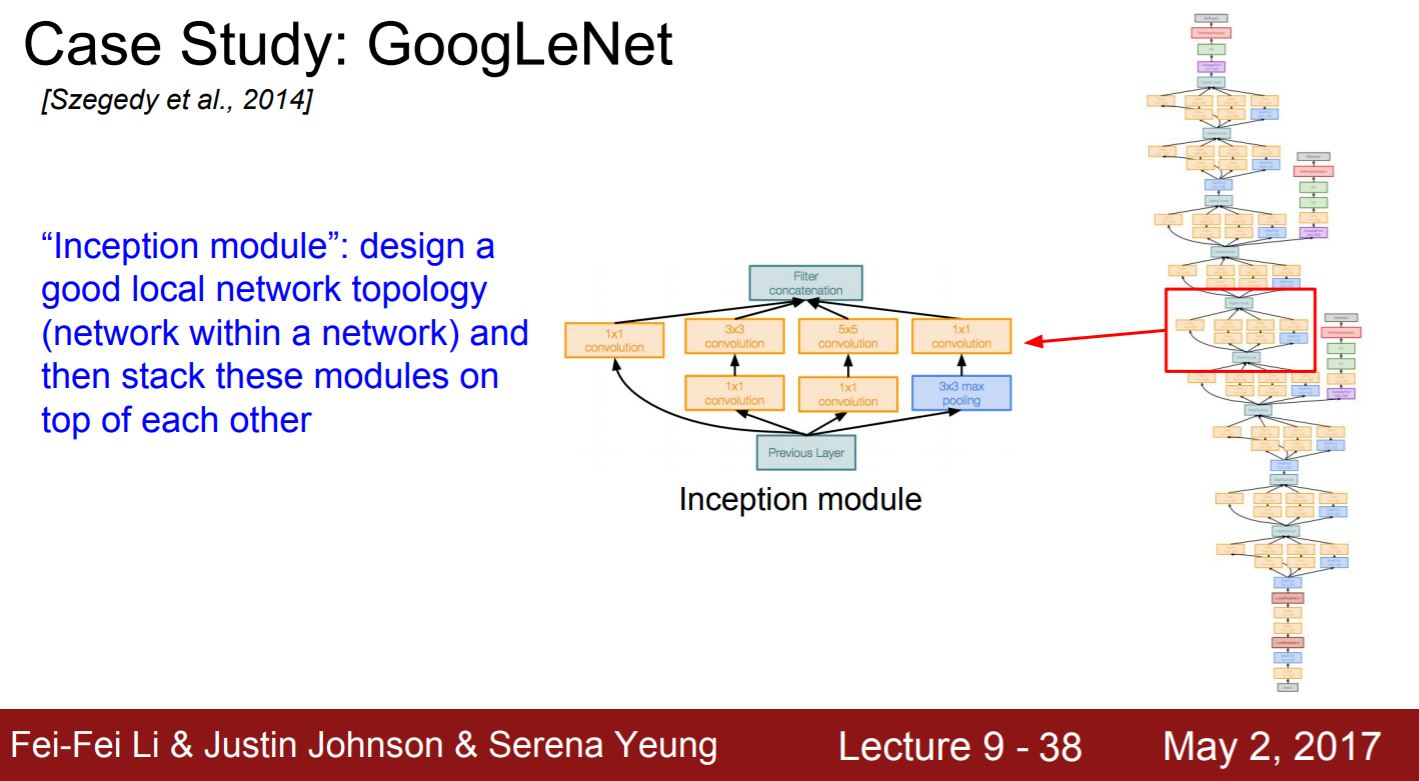

#### Inception Module 사용

good **local topology**

stack lot of local topology at least each other.

- Apply parallel filter operations on the input from previous layer:
  - Multiple receptive field sizes for convolution (1x1, 3x3, 5x5)
  - Pooling operation (3x3)
- Concatenate all filter outputs together depth-wise

그런데 계산량이라는 큰 문제가 있었으니..

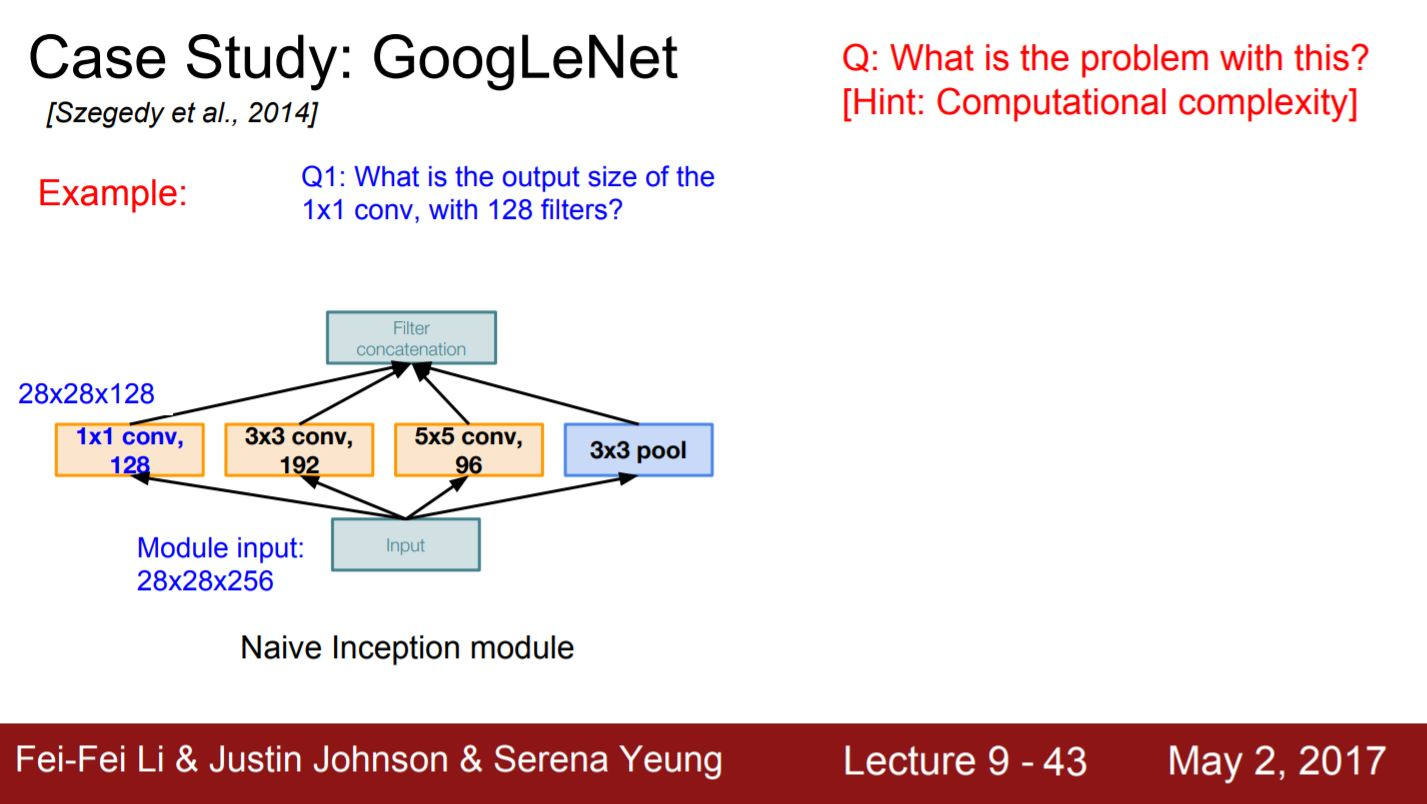

**First 1x1 Conv**의 결과: *28x28x128*이 됨.
  - 1x1: 크기가 1. w, h는 변하지 않으나 depth가 줄어든다.
  - pooling layer: keep dim



**Next 3x3 Conv**의 결과: 28x28x192
- *Zero padding*: shape 변하지 않고, **depth**만 변화

똑같은 원리로 Next 5x5 Conv에서도 depth만 변하며 그 output은 28x28x96이 된다.

**Last 3x3 Pool**의 결과: 28x28x256
  - **Stride가 1**이라서 크기가 줄어들지 않는다.
  - blur 효과

#### ConCate

output size is 28x28x(128+192+96+256) = 28x28x672

output would be input of previous module

- total dept can *only grow*, *keep increasing* as you go up

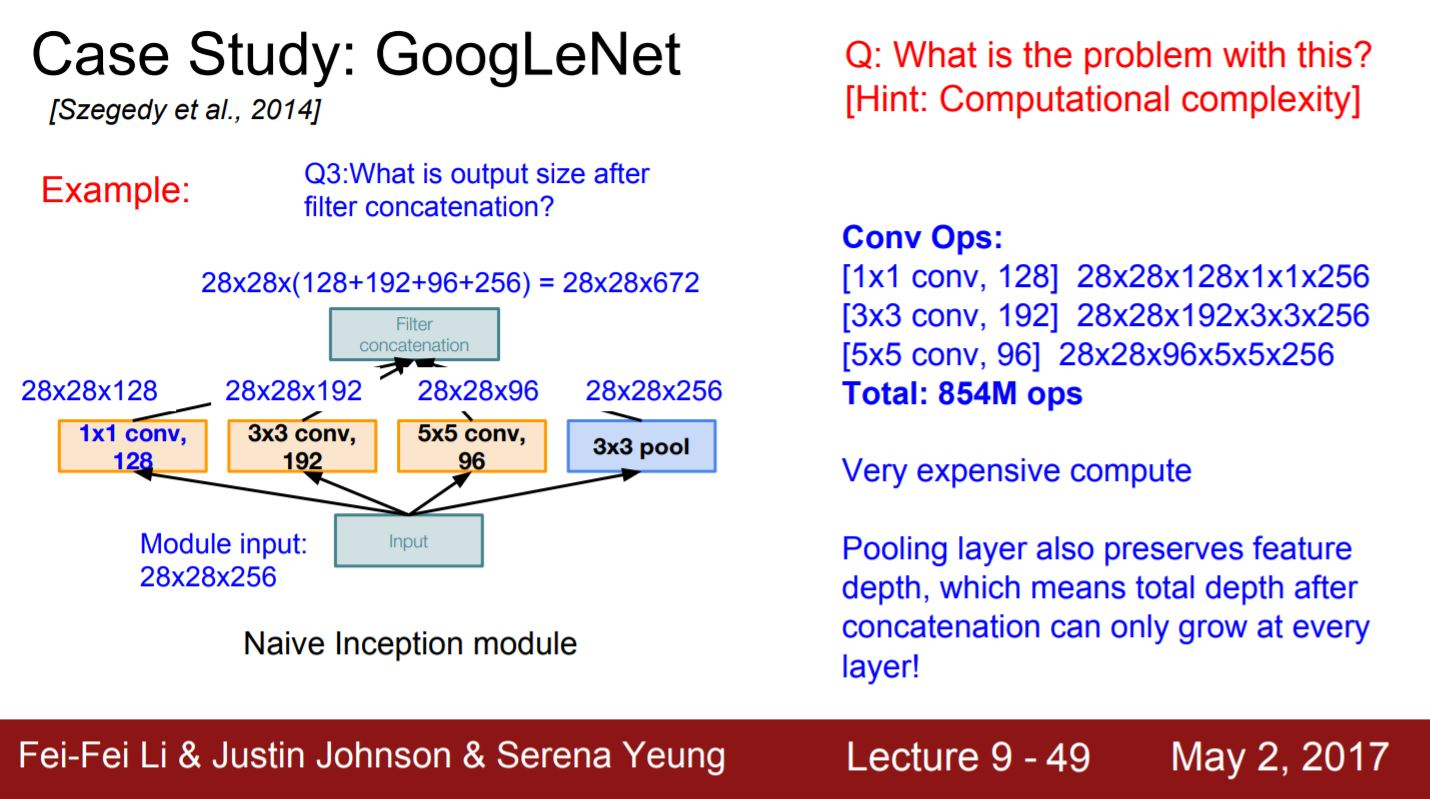

many ops → computing cost 증가함

**Concate 시 depth**가 매우 깊어지기 때문.



### Bottleneck

Bottleneck can be solution. "Bottleneck" layers that use 1x1 convolutions to reduce feature depth.

w, h는 유지하면서 depth는 감소시킬 수 있는 Conv1의 특징을 이용하여 입력을 더 낮은 차원으로 보냄.

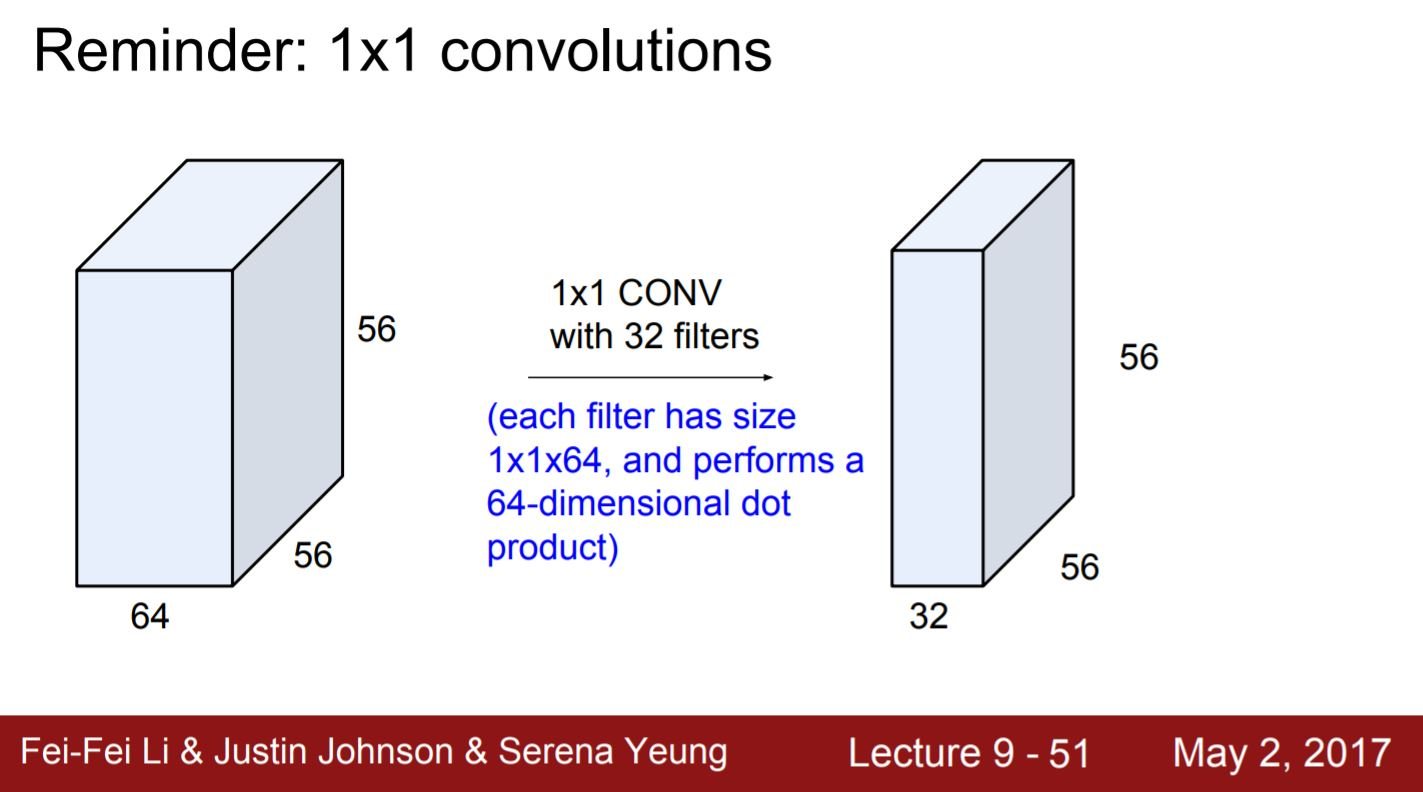

each filter has size 1x1x64, and performs a 64-dimensional dot product

preserves spatial dimensions, reduce depth. Projects depth to lower dimension(combination of feature maps)

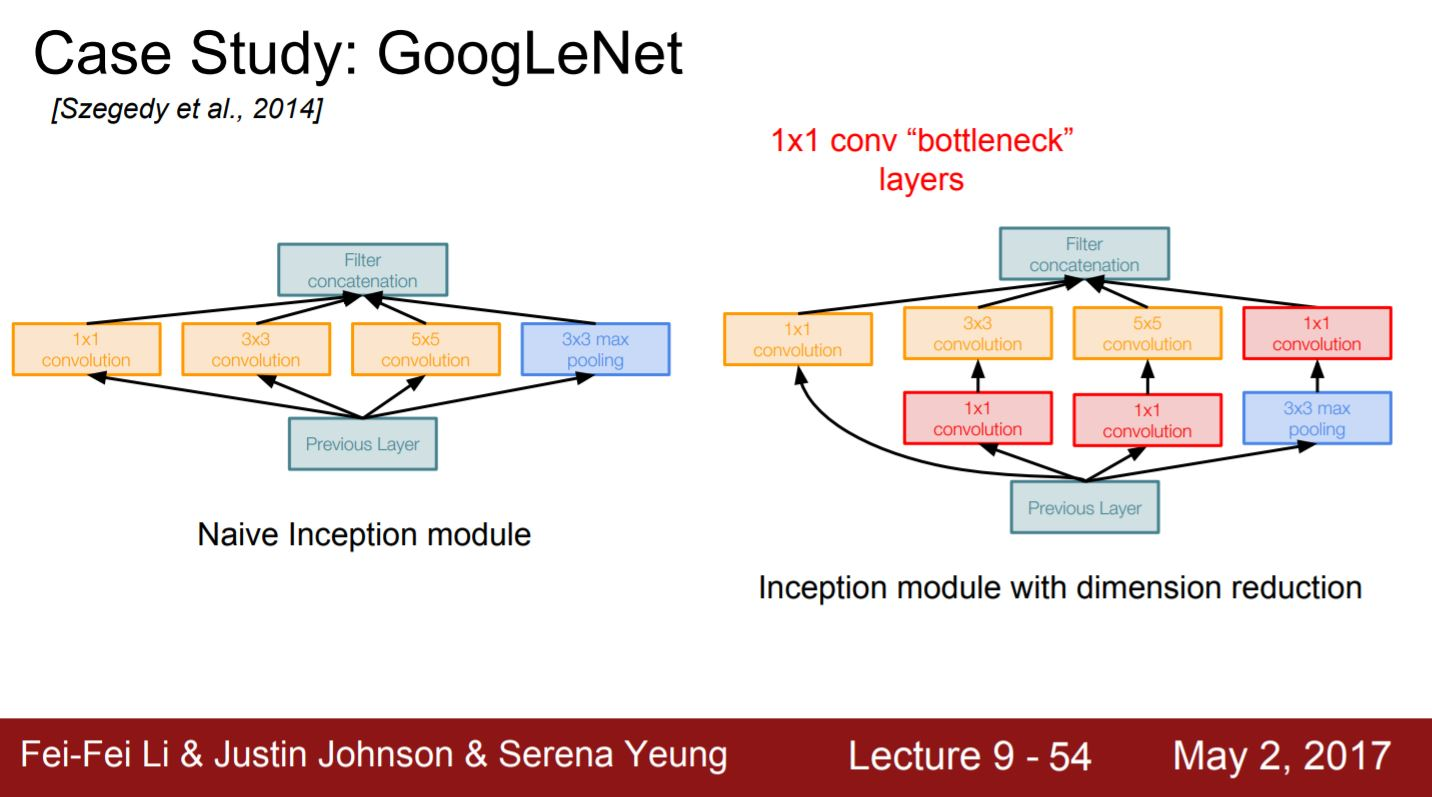

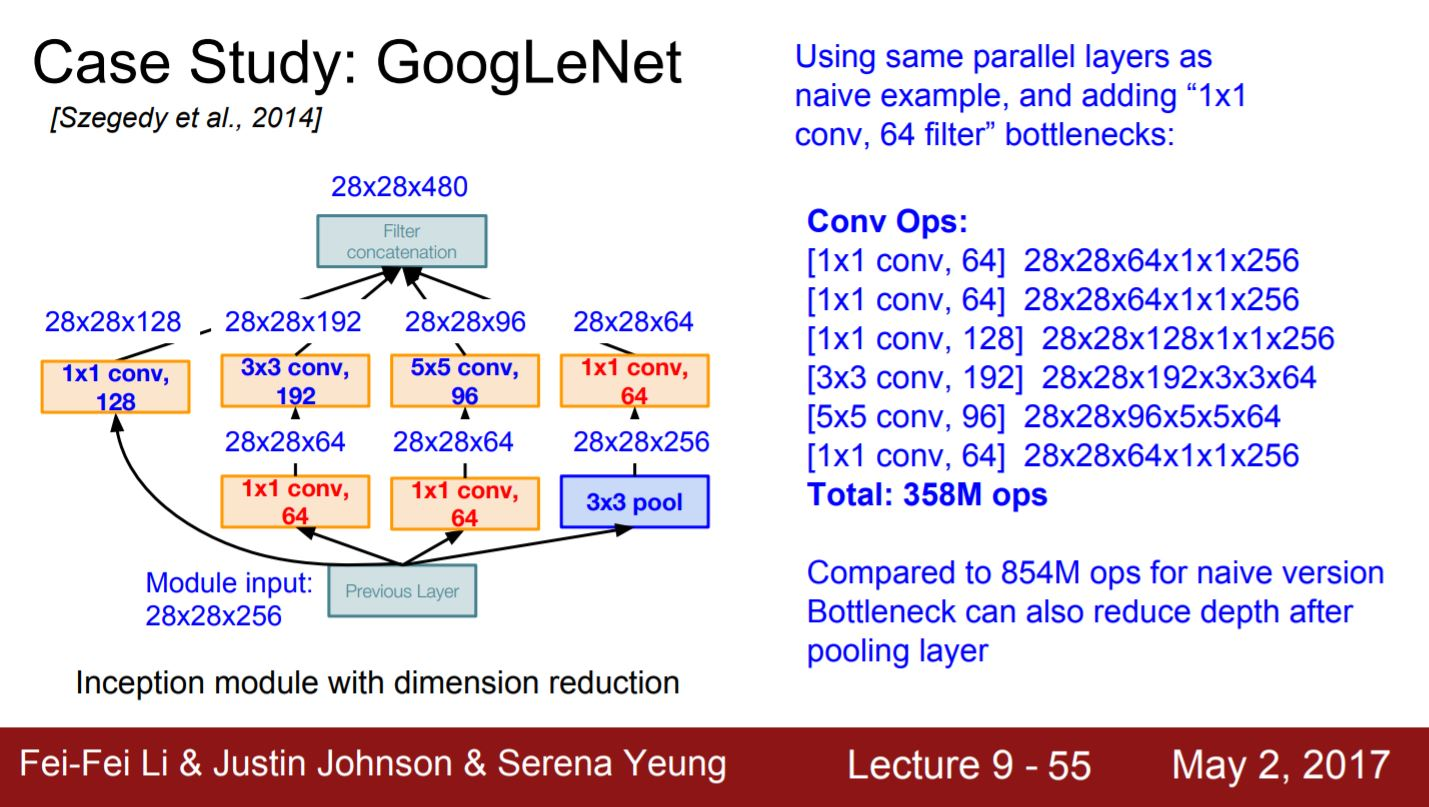

그래서 inception module에 **1x1 Conv (1x1 Conv BOTTLENECK layers)** 추가하고 연산량을 다시 계산해 보면, 확실히 저번보다 reduce된 값이 나온다. 854M ops for naive version.. Bottleneck: 358M ops 

이렇게 1x1 Conv 활용하여 computation cost 줄여 준다.

정보 손실 발생 가능

Linear combination with input features with redundancy and add non-linear → deeper networks

**Stack Inception modules with dimension reduction on top of each other!**

### Full GoogLeNet architecture

**22 total layers with weights(including each parrallel layer in an Inception module)**

- Stem Network: Conv-Pool-2 x Conv-Pool
  - 일반적인 네트워크 구조

- Stacked Inception Modules

- Classifier output
  - **global average pooling** 사용 (fully connected 대신)
    - 시행 후 바로 classification 가능
    - 앞서 추출된 vector들에 대한 pooling 만으로도 충분
  - Parameter ↓ overfitting ↓
  - after that, FC layer → Softmax

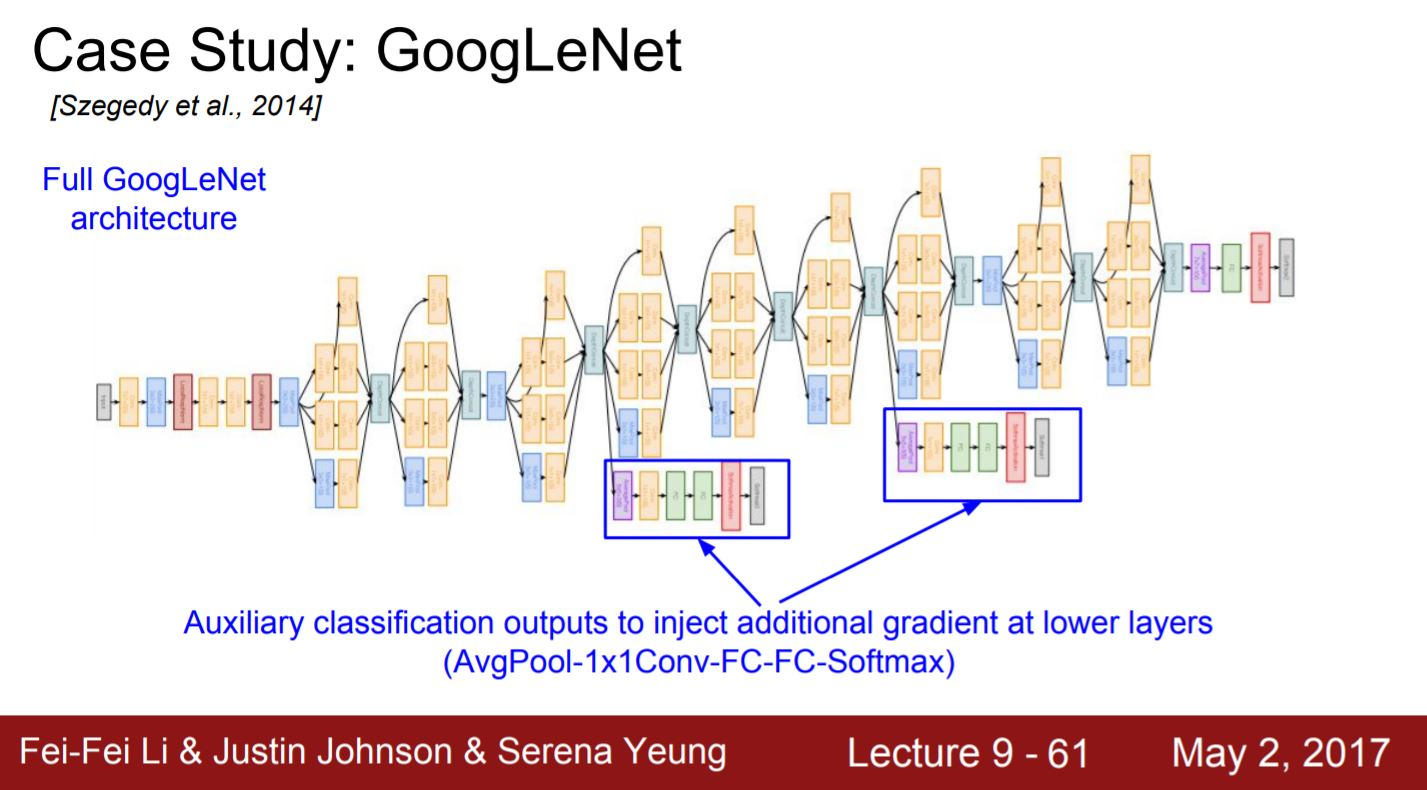

- Auxiliary Classifier: mini network
  - AvgPool - 1x1Conv - FC - FC - Softmax
  - loss

Because network is **deep**, it can loose **gradient**

Can get additional gradient, can help train of middle layer


**Deeper networks, with computational efficiency**

- 22 layers

- Efficient INCEPTION module

- No FC layers

- 12x less params than AlexNet

- ILVRC'14 classification winner

## ResNet

**Revolution of Depth**

152 layers

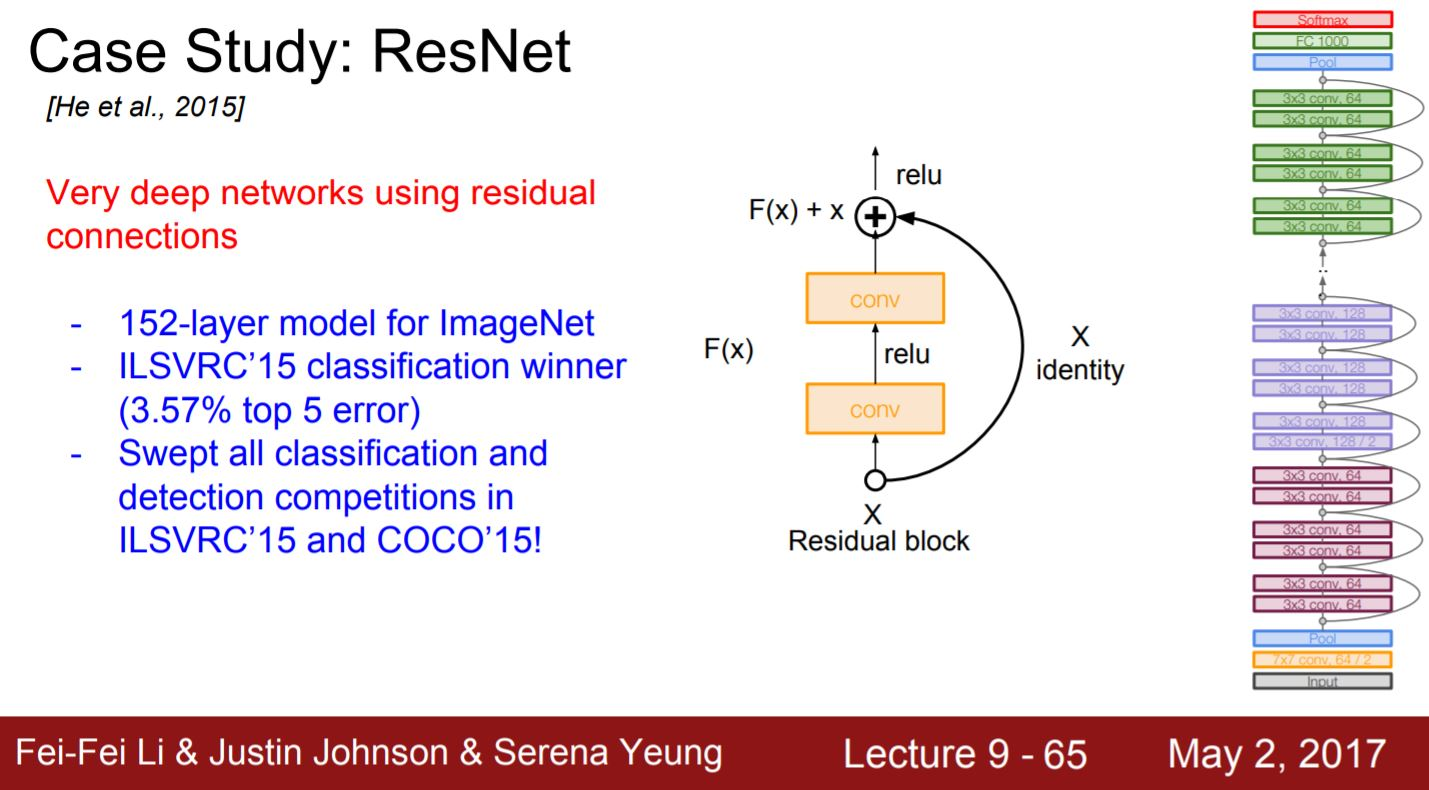

**Residual Connections 사용**

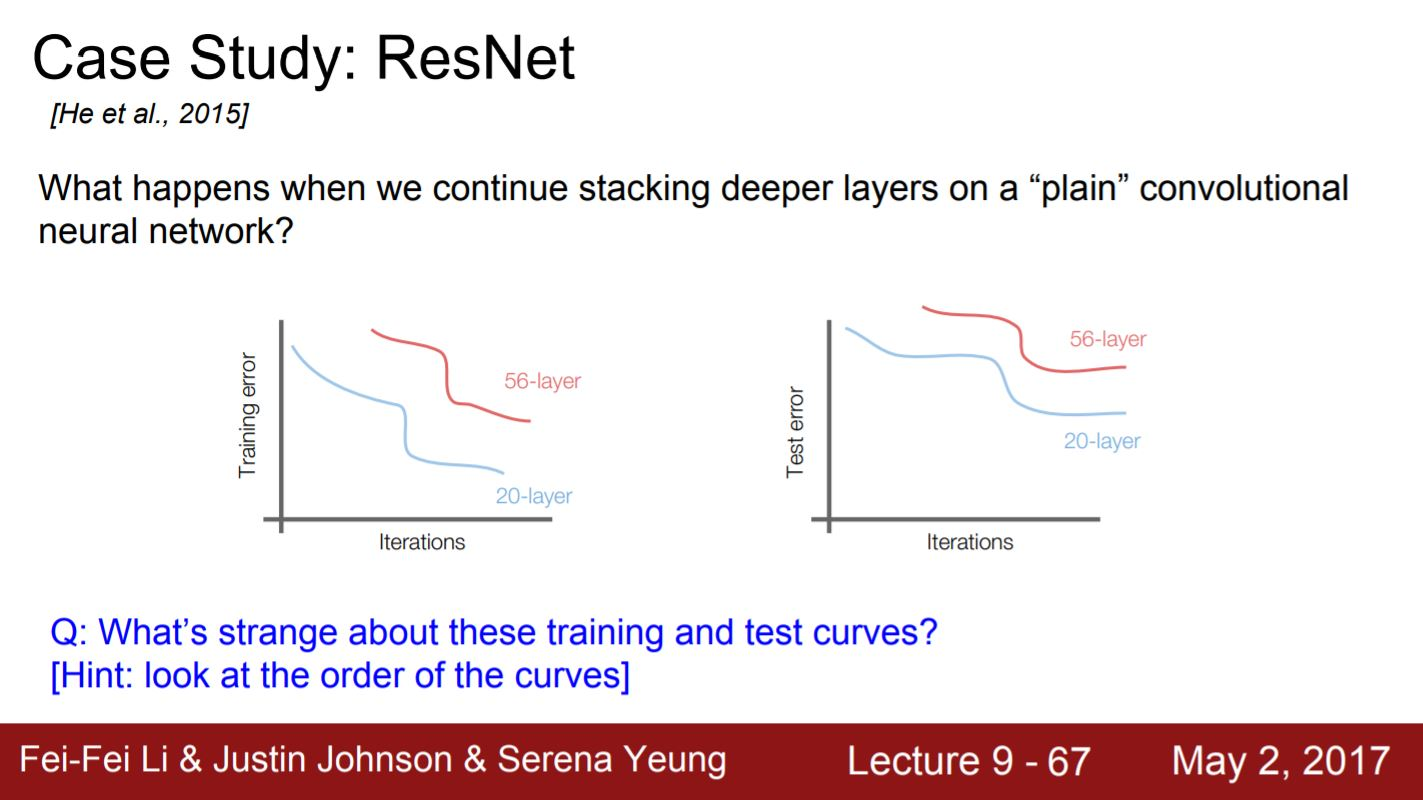

56-layer model performs worse on both training and test error -> The deeper model perfomrs worse, *but it's not caused by overfitting!*


layer deeper하다고 무조건 성능이 좋아지는 것은 아님. 

- Generally, layer deep → overfitting ↑
  - but not overfitting.. 
  - deeper model 학습 시 **optimization**에 문제?

더 깊은 모델 학습 시, optimization에 문제가 생긴다는 가설을 수립하고 그에 대한 검증을 진행함. - **모델이 깊어질수록 최적화가 어렵다**

- Hypothesis: the problem is an *optimization* problem, deeper models are *harder to optimize*
  - The deeper model should be able to perform at least as well as the shallower model
  - A solution by construction is copying the learned layers from the shallower model and setting additional layers to identity mapping.

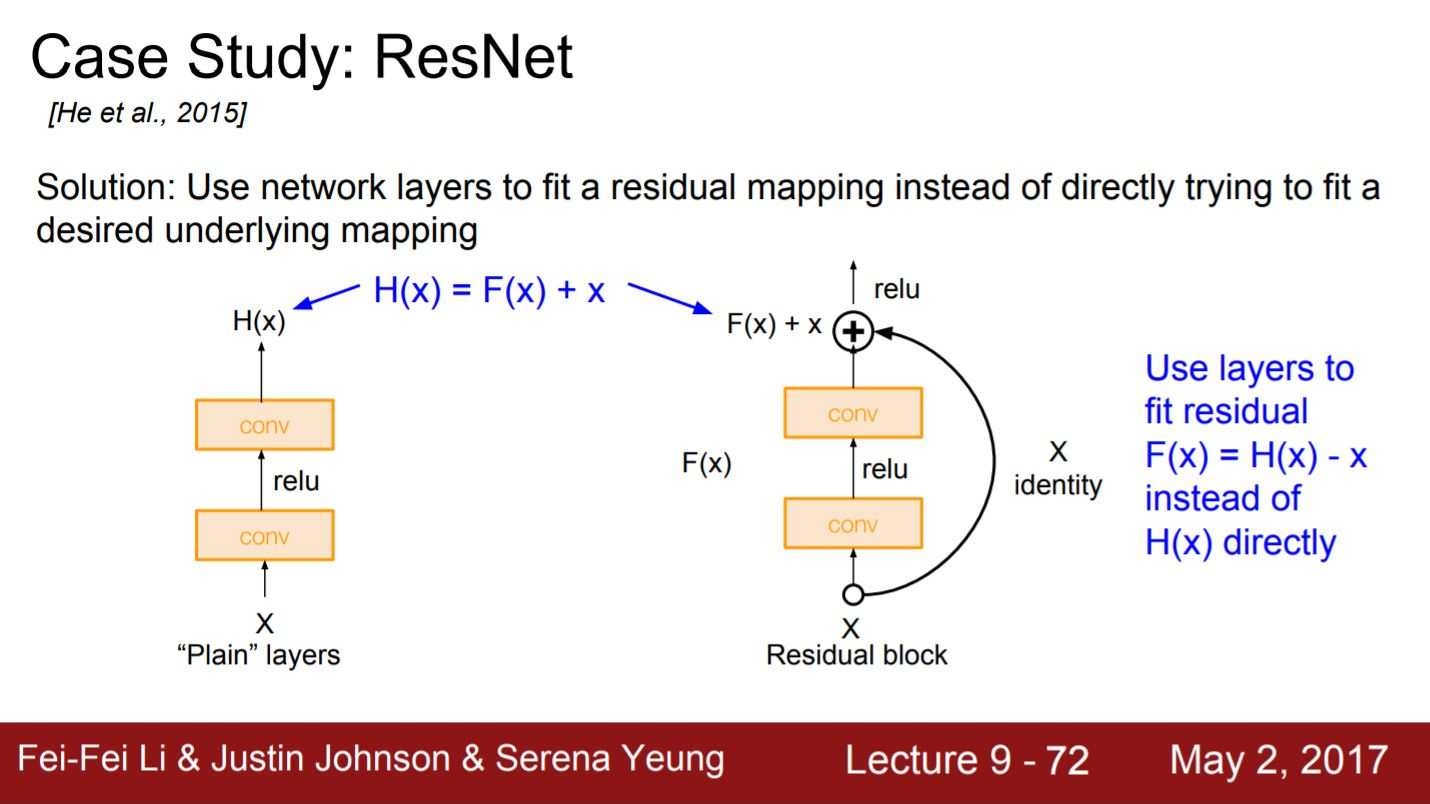

레이어를 단순하게 **쌓기**만 하는 것은 아님.

Direct Mapping: X → *Residual Mapping* 형식으로 블럭 쌓음

use layers to fit residual **F(x) = H(x)-x** instead of H(x) directly

*H(x)*가 아닌 **H(x)-x**를 학습하도록 모델을 제작함.

즉, 최종 출력값은 input X + residual *F(x)*

- if: input = output -> residual == 0이고 따라서 다음 input이 0이 됨. (output is zero)
  - F(x) would be 0 (residual = 0)
  - so just make weight to 0
    - 출력을 손쉽게 Identity로 제작해 줄 수 있음

- Network는 Residual만 학습하면 됨 → 출력값도 결국 입력 x에 가까운 값

input - identity mapping으로 그대로 output으로 내보냄. then, real layer는 *delta*만 학습하면 되고, 이것은 x에 대한 residual.

#### Direct mapping - H(x) vs Residual - F(x)?

H(x)를 학습하는 것보다 F(x)를 학습하는 것이 더 쉽다: ResNet 연구자들이 제시한 **가설**.

Residual Train - Train delta of X (X에 대한 변화량)

if 가설이 참이라면 → 모델의 일부는 학습된 shallow layer, 나머지 레이어들은 indentity라면 잘 동작해야 함

즉, 대부분의 레이어가 잘 동작하려면 레이어의 *output*이 *Identity*에 가까워져야 할지도 모른다.

따라서, **"Identity(Input) + 변화량(Delta)만 학습시키면 될 것 같다."**

- if) output = input (identity) → 그저 F(x) = 0이 되면 됨. 상대적으로 train 시키기가 쉬움
  - → 이런 방식으로 Identity Mapping에 가까운 값 획득 가능

- 가설, 아직 입증된 바 없음, 학계 내에서도 Resident에 대한 필요성 생각 여부가 갈림

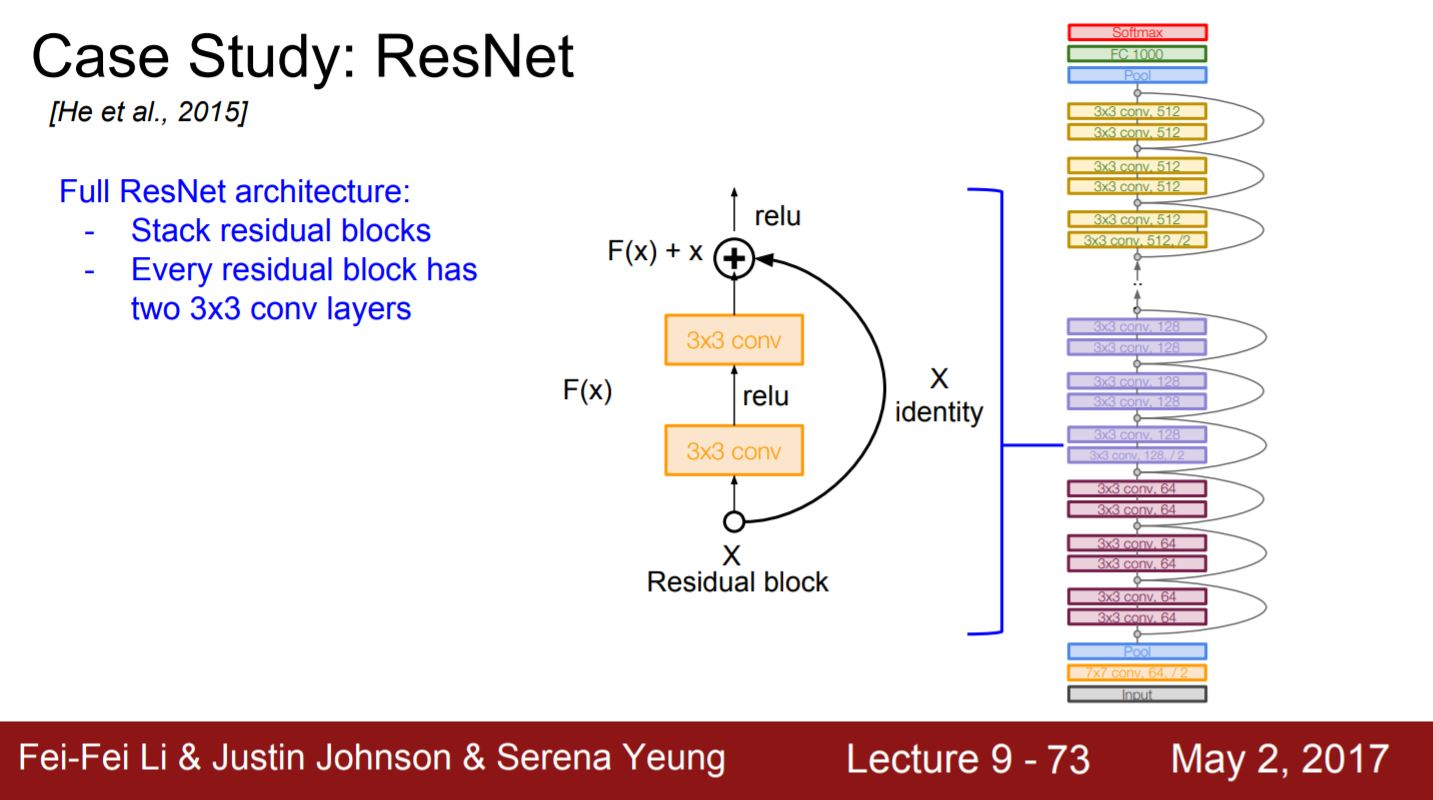

**Every residual blocks has to 3x3 conv layers**
- One Residual Blocks: 2 3x3 Conv1 layer
  - Stack these blocks very deep (by 15 0Layers)

**Downsample**
- Periodically, double # of filters and downsample spatially usind *stride 2*
  - /2 in each dimension

**Beginning**
- Additional conv layer at the beginning

**No FC Layers at the end**
- only FC 1000 to output classes
- Instead, use *Global Average Pooling Layer**
  - GAP: Average Pooling all of a map



Total depths of 34, 50, 101, or 152 layers for ImageNet

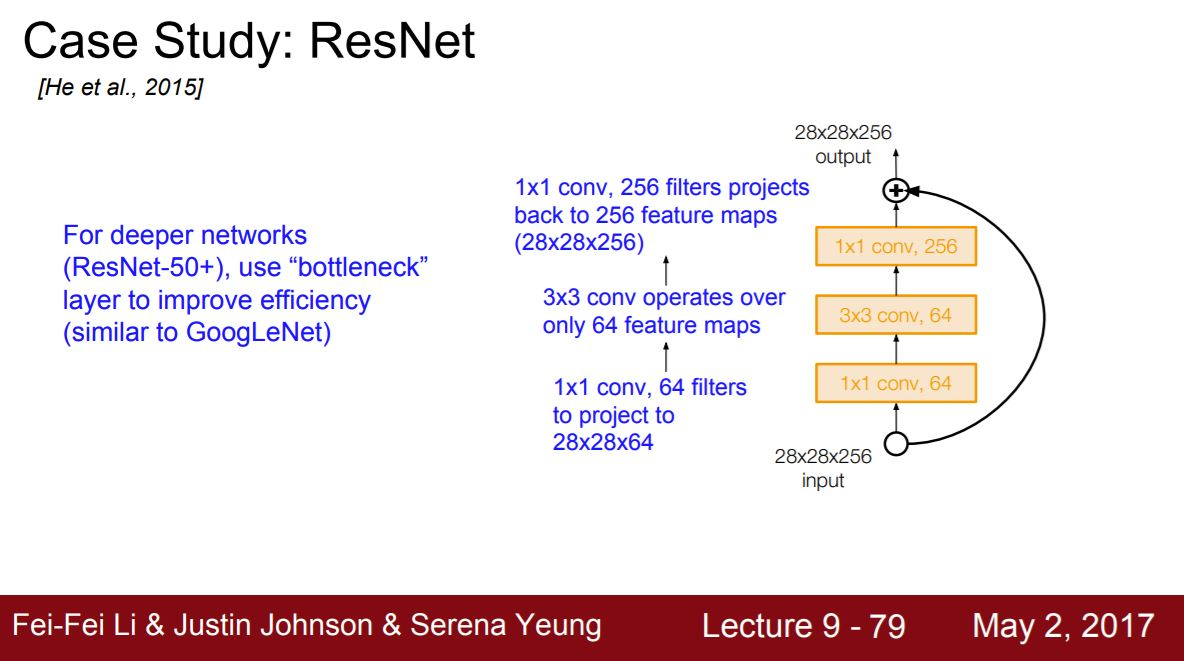

#### Bottleneck Layers 도입 - Deeper ResNet

모델 Depth 50 이상일 때 도입한다.

GoogLeNet에서의 방법과 유사하게, 1x1 conv Net 도입 → 초기 필터의 depth 감소시킴

ex.
> 28x28x256 → 1x1 ConvNet → 28x28x64
>
> → 3x3 ConvNet
>
> 28x28x64 → 1x1 ConvNet → 28x28x256

3x3 conv의 계산량이 감소

초기 필터의 depth 감소시키고, Conv3D를 시행한 후 다시 Conv1 이용해서 늘림





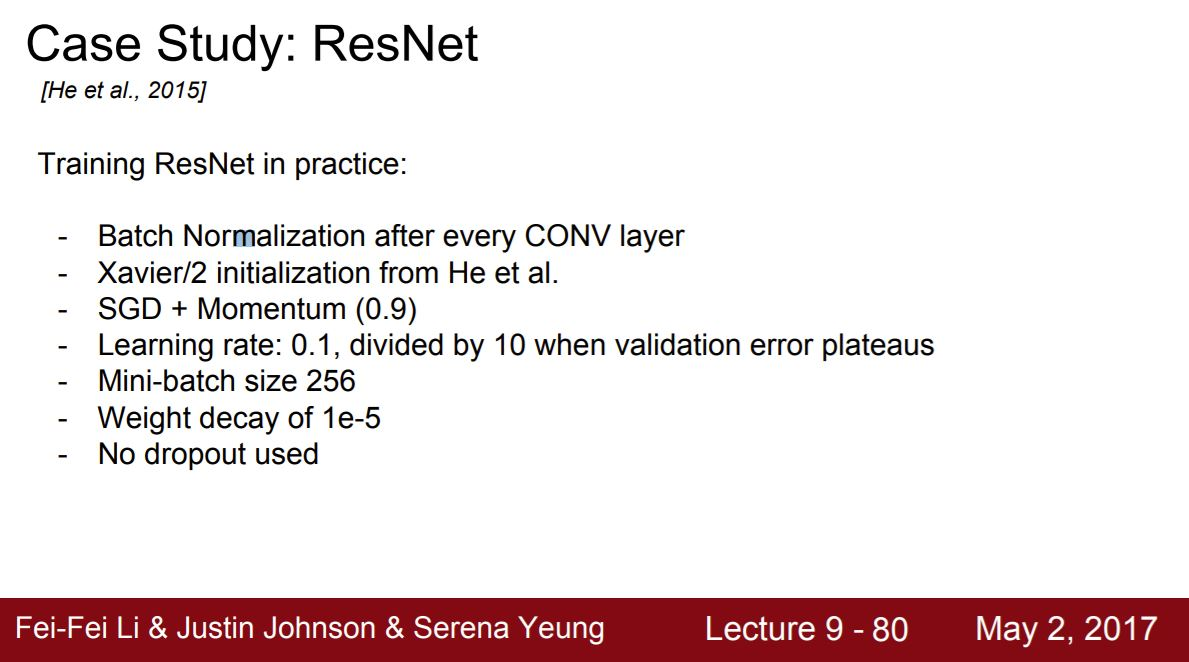

---

## Comparing Complexity

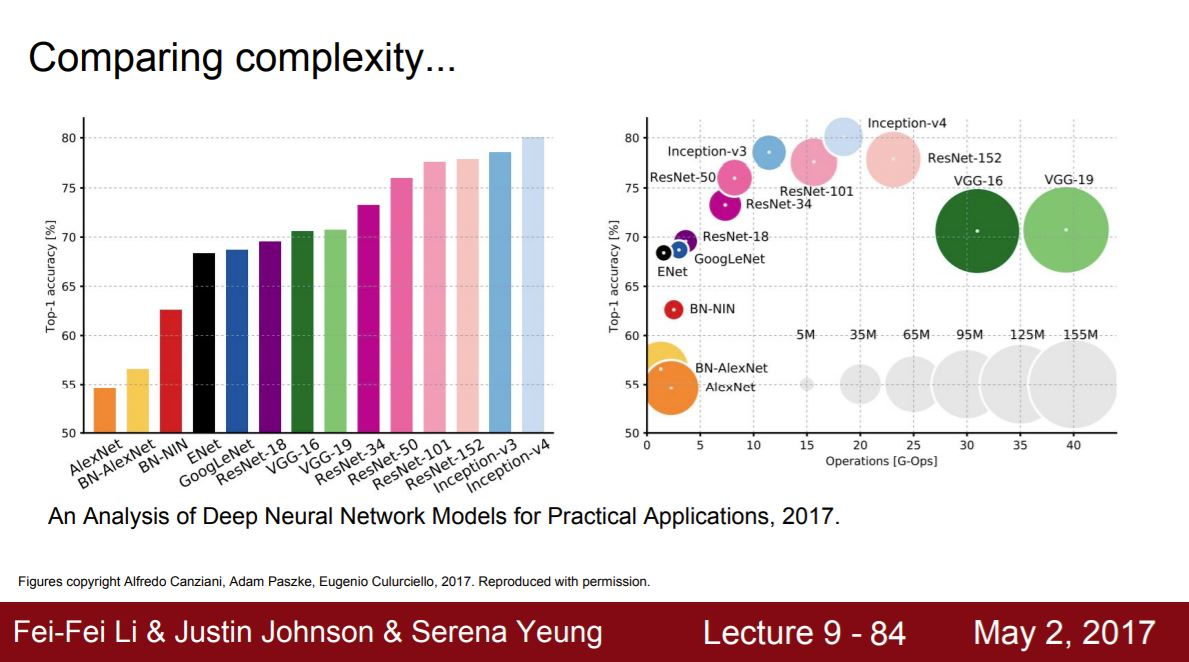

Accuracy: Inception-v4 ResNet+Inception이 좋음

VGGNet: Highest Memory, more operations

GoogLeNet: most efficient

AlexNet: Smaller compute, still memory heavy, lower accuracy

ResNet: Moderate efficiency depending on model, highest accuracy

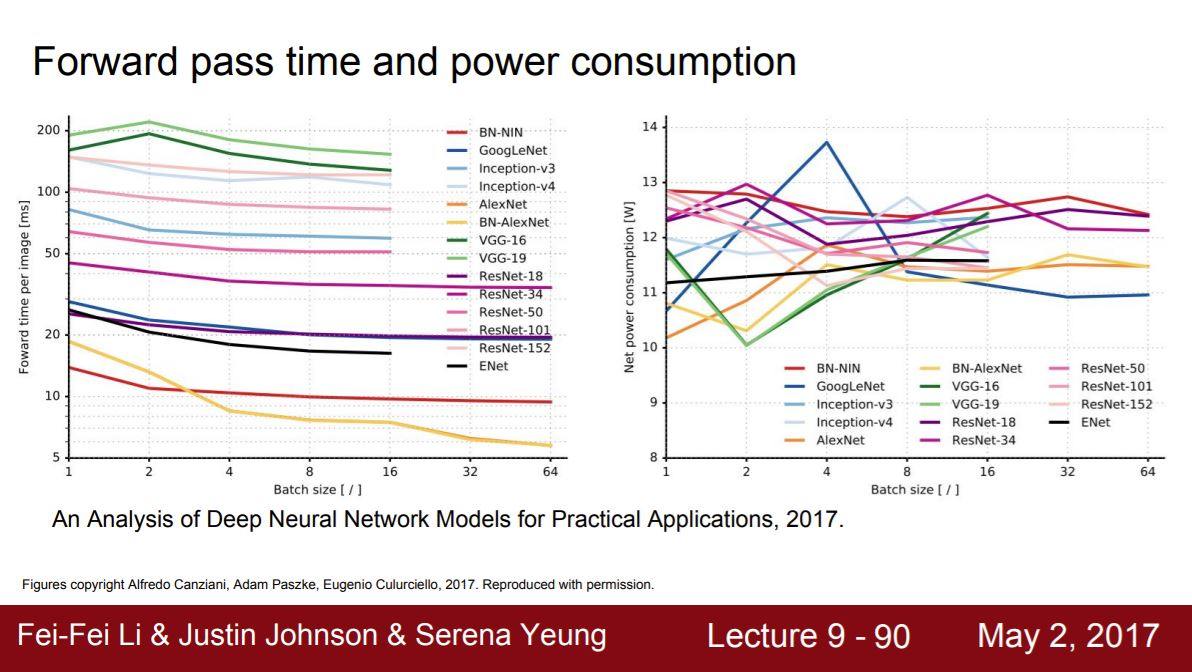

---

other architectures to know

## Network in Network (NiN)

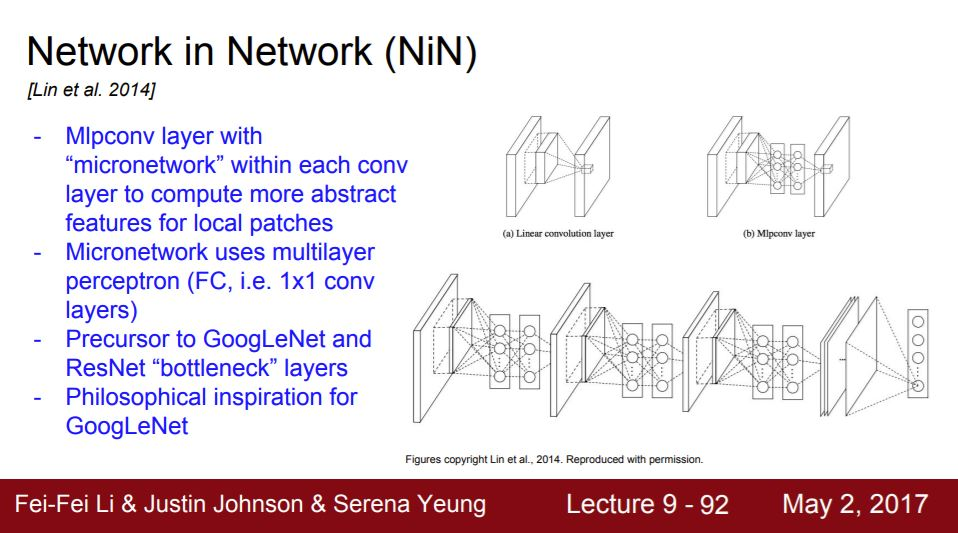

기본 아이디어: MLP conv layer

네트워크 안에 작은 네트워크 삽입

각 Conv Layer 안에 MLP(Multi Layer Perception) 쌓음 → FC Layer 몇 개를 쌓음

- 기본적으로 FC-Layer 사용
  - 1x1 Conv Layer

- GoogLeNet, ResNet보다 먼저 **Bottleneck** 개념 정립

## Improving ResNet

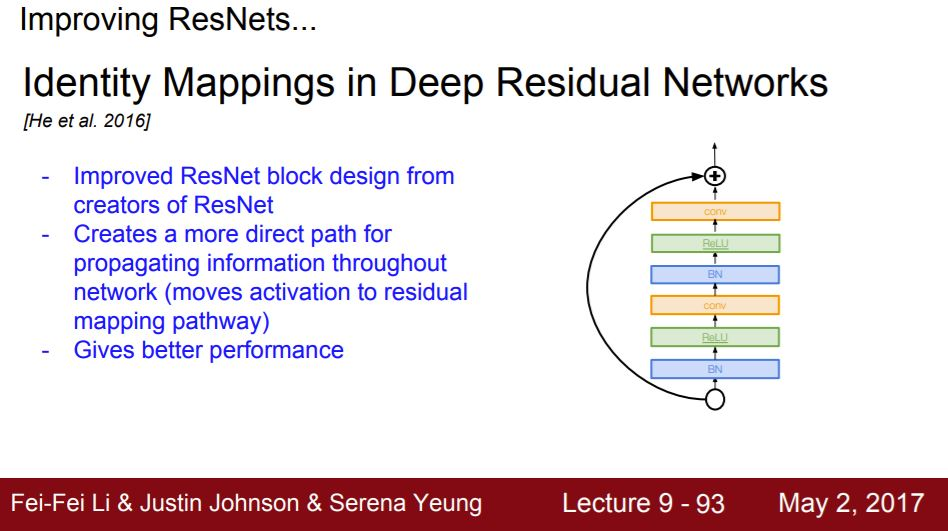

### 2016 ResNet

ResNet의 **Block Path**를 조정함

- 새로운 구조: direct path ↑
  - 정보들이 forward로 잘 전달되고, backprop 잘될 수 있도록 개선



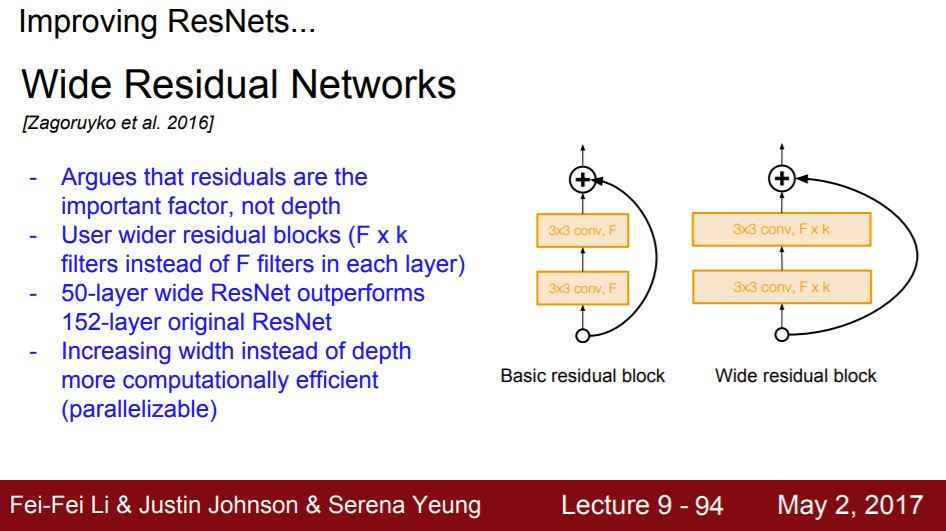

### Wide Residual Network

기존의 ResNet 논문들이 deep에 열중 → 중요한 것은 **depth**가 아닌 **residual**이라는 주장

- Residual Connection 존재  → deeper 필요 X
  - **residual block**더 넓게 제작
  - 즉, conv layer의 filter 더 많이 추가

- 기존: 블록 당 F개의 filter
  -  → **F*K**개의 filter

50 layer만 있어도 기존 ResNet-152보다 성능 좋음 입증



Depth 대신 **filter width** 늘릴 시 추가적 이점: 계산 효율 증가 (병렬화 용이)

Depth increase - Sequential Increase



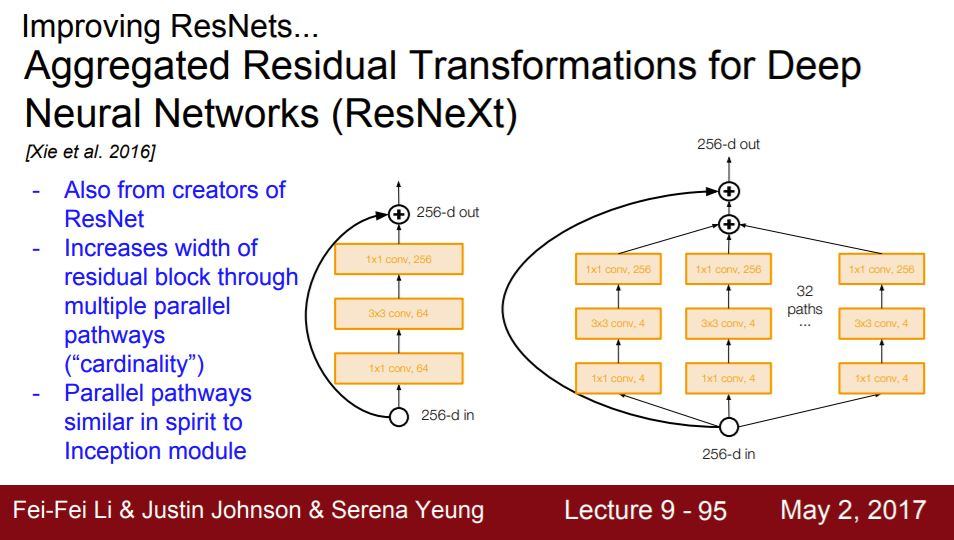

### ResNeXt

*ResNet + inExeption*

resdiaul block의 width 집중 - filter의 수를 늘림

**multiple parrallel pathways**를 Residual Block 내에 추가.

pathway의 총 합을 **cardinality**라고 부름.

- ResNeXt / Wide ResNet 연관성
  - 하나의 bottleneck ResNet block은 비교적 작지만, thinner blocks를 병렬로 여러 개 묶음.

- ResNeXt / Inception Module 연관성
  - 여러 Layer을 병렬적으로 묶음

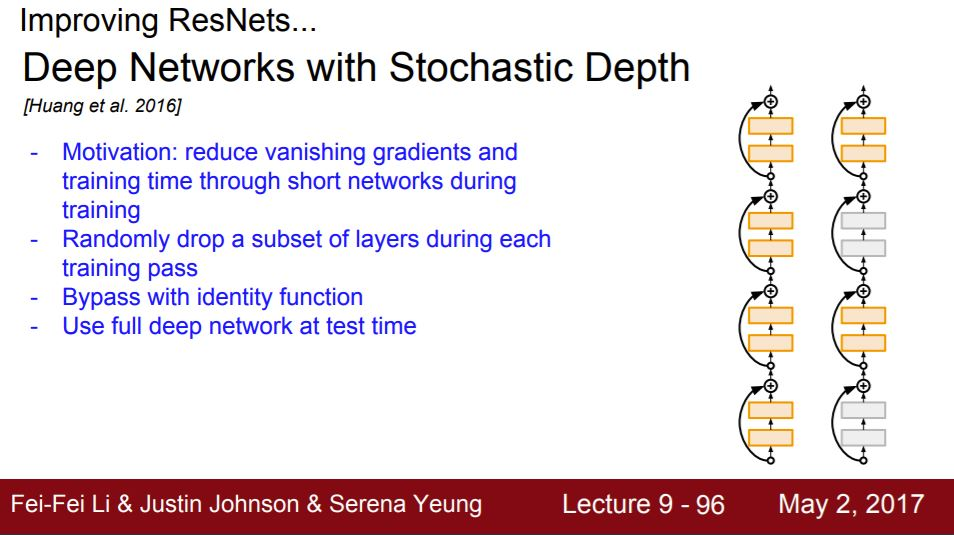

### Stochastic Depth

topic: depth

network deeper → vanishing gradient problem

gradient vanishing 문제 O

- 기본 idea: train time에 레이어의 일부 제거 → short network가 train 더 용이
  - 일부 Network 골라서 *identity connection*으로 만듦 → short network로 만듦

dropout과 유사

- test time: full deep network 사용

## Beyond ResNets

Non-ResNets 중 ResNet과 비등한 성능의 모델들 존재

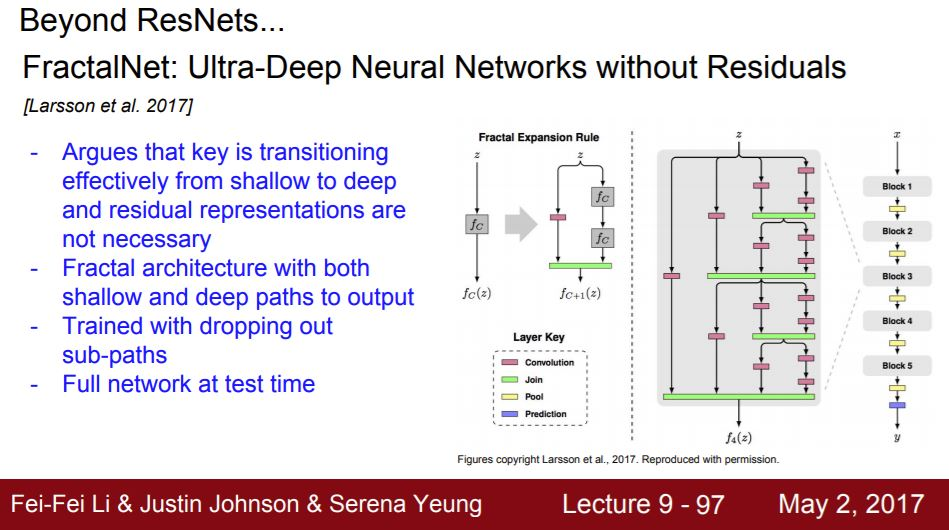

### FractalNet

**residual connection**이 쓸모없다고 주장

shallow/deep network의 정보 모두를 잘 전달하는 것이 중요

- **fractal**한 모습
  - shallow/deep path를 출력에 모두 연결

다양한 경로 존재

- Train time: dropout처럼 일부 경로만을 이용하여 train
- Test time: full network 사용

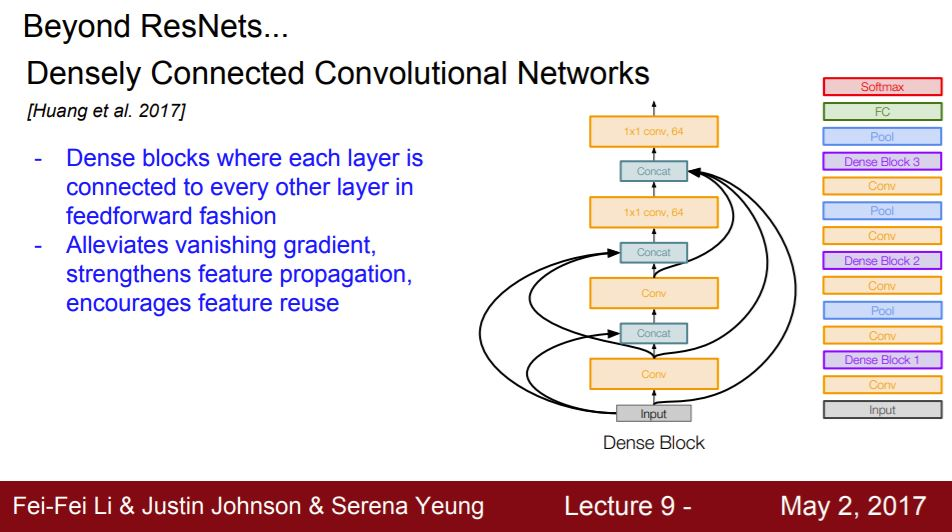

### DenseNet

**DENSEly Connected Convolutional NETworks**

Dense Block이라는 것이 존재

한 레이어가 그 레이어 하위의 모든 레이어와 연결됨

- Network의 input image가 모든 layer의 input으로 들어감
- every layer의 output이 각 layer의 output과 concat
- 그리고 이 값이 conv layer의 input 
  - 과정에서 dim 줄여 주는 과정 포함

Dense Connection can reduce vanish gradient problem

dense connection: feature 더 잘 전달, 더 잘 사용 가능하도록 함 - 각 레이어의 output이 다른 레이어에서도 여러 번 사용될 수 있기 때문

## Efficient Networks

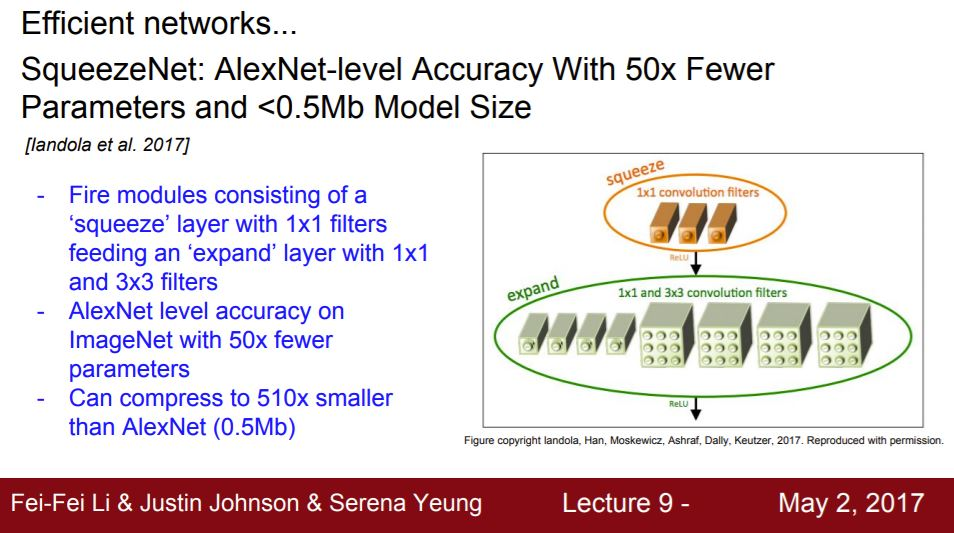

GoogLeNet: efficient model에 대한 direction 제시

### SqueezeNet

very effecient, **fire modules** 도입

- *squeeze layer*: 1x1 filters
  - output of these layer: input of 1x1/3x3 *expand layer*

ImageNet에서 AlexNet만큼의 Accuracy 보임, parameter는 50배 더 적음

더 압축: AlexNet보다 500배 더 작아지게 됨